In [1]:
#carina
#2021-07-20

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale

In [3]:
eventsadapt_score_dir = '/Users/carinakauf/repos/lm-event-knowledge/model_scores/new-EventsAdapt'

In [4]:
# # custom function to read a datatable

def read_data(data_dir,filename):
    df = pd.read_csv(os.path.join(data_dir,filename), sep='\t', header=None)
    if len(df) != 1648:
        print(f'unexpected number of sentences in file: {filename}')
        return None, None
    if len(df.columns) == 3:
        df.columns = ['SentenceNum', 'Sentence', 'Score']
        df['ItemNum'] = df['SentenceNum']//4
        #synonym sets are right after each other i.e., ItemNum 0&1
        a = np.array([0,0,1,1])
        df['ItemNum_voice'] = np.tile(a,int(len(df)/4))
        voice = np.array(['active','active','passive','passive'])
        df['Voice'] = np.tile(voice,int(len(df)/4))
        df['Plausibility'] = ['Plausible' if list(df['SentenceNum'])[ind]%2 == 0 else 'Implausible' for ind in range(len(df))]
        
        sentences = list(df['Sentence'])
        new_sents = [elm.rstrip(" .") + "." if " ." in elm else elm for elm in sentences]
        df['Sentence'] = new_sents
        
    else:
        print(f'unexpected number of columns in file: {filename}')
        return None, None
    
    df['Metric'] = np.array([filename.split('.txt')[0]]*len(df)).flatten()
    
    #normalize scores
    df['NormScore'] = scale(df['Score']) #from sklearn.preprocessing import scale
    
    return df, new_sents

In [5]:
frames = []
model_sentence_dir = {}
for elm in os.listdir(eventsadapt_score_dir):
    df, new_sents = read_data(eventsadapt_score_dir,elm)
    model_sentence_dir[elm] = new_sents
    if df is not None:
        frames.append(df)
ann_df = pd.concat(frames)
ann_df

unexpected number of sentences in file: new-EventsAdapt.xlnet-large-cased.l2r.txt
unexpected number of sentences in file: new-EventsAdapt.roberta-large.l2r.txt
unexpected number of sentences in file: new-EventsAdapt.bert-large-cased.l2r.txt
unexpected number of columns in file: new_EventsAdapt_surprisal_scores_tinylstm.txt
unexpected number of columns in file: new_EventsAdapt_surprisal_scores_ngram.txt


,SentenceNum,Sentence,Score,ItemNum,ItemNum_voice,Voice,Plausibility,Metric,NormScore
0,0,The raider caught the illness.,-10.487345,0,0,active,Plausible,new-EventsAdapt.xlnet-large-cased.verb-prob,0.581362
1,1,The illness caught the raider.,-16.562662,0,0,active,Implausible,new-EventsAdapt.xlnet-large-cased.verb-prob,-0.979956
2,2,The illness was caught by the raider.,-12.388975,0,1,passive,Plausible,new-EventsAdapt.xlnet-large-cased.verb-prob,0.092655
3,3,The raider was caught by the illness.,-14.923611,0,1,passive,Implausible,new-EventsAdapt.xlnet-large-cased.verb-prob,-0.558730
4,4,The marauder contracted the disease.,-15.842419,1,0,active,Plausible,new-EventsAdapt.xlnet-large-cased.verb-prob,-0.794858
...,...,...,...,...,...,...,...,...,...
1643,1643,The plumber was devastated by the foreman.,0.000000,410,1,passive,Implausible,newsentences-EventsAdapt.update-model.TF-add,-0.791301
1644,1644,The sergeant identified the sniper.,0.375275,411,0,active,Plausible,newsentences-EventsAdapt.update-model.TF-add,0.859682
1645,1645,The sniper identified the sergeant.,0.420504,411,0,active,Implausible,newsentences-EventsAdapt.update-model.TF-add,1.058664
1646,1646,The sniper was identified by the sergeant.,0.000000,411,1,passive,Plausible,newsentences-EventsAdapt.update-model.TF-add,-0.791301


In [6]:
#check which sentences from the human ratings file are NOT in the sentences used here.
sentence_file = '/Users/carinakauf/repos/lm-event-knowledge/human_ratings/2_EventsAdapt_plausibility/newsentences_EventsAdapt.csv'
sentence_df = pd.read_csv(sentence_file)
sentence_df
sentence_df.rename(columns={'Unnamed: 0':'SentenceNum'}, inplace=True)
sentence_df.rename(columns={'ItemNumber':'ItemNum'}, inplace=True)
sentence_df.rename(columns={'Stimulus':'Sentence'}, inplace=True)
sentence_df.rename(columns={'EvType':'TrialType'}, inplace=True)
sentence_df_new = sentence_df[['Sentence', 'Voice', 'TrialType']]
sentence_df_new

,Sentence,Voice,TrialType
0,The raider caught the illness.,active,AI
1,The illness caught the raider.,active,AI
2,The illness was caught by the raider.,passive,AI
3,The raider was caught by the illness.,passive,AI
4,The marauder contracted the disease.,active,AI
...,...,...,...
1659,The plumber was devastated by the foreman.,passive,AAR
1660,The sergeant identified the sniper.,active,AAR
1661,The sniper identified the sergeant.,active,AAR
1662,The sniper was identified by the sergeant.,passive,AAR


In [7]:
sentences_humans = list(sentence_df_new["Sentence"])
sentences_anns = list(np.unique(ann_df["Sentence"]))
print(len(sentences_humans), len(sentences_anns))

1664 1696


In [8]:
for key, value in model_sentence_dir.items():
    try:
        print(key, type(value), len(value))
    except:
        print(f"ERROR for {key}")
        print(value)

new-EventsAdapt.xlnet-large-cased.verb-prob.txt <class 'list'> 1648
new-eventsAdapt_gpt2-xl_full.txt <class 'list'> 1648
new-EventsAdapt_v2_sdm.txt <class 'list'> 1648
new-EventsAdapt.xlnet-large-cased.last-word-prob.txt <class 'list'> 1648
new-EventsAdapt.bert-large-cased.sentence-probs-pseudolog.txt <class 'list'> 1648
newsentences-EventsAdapt.scores_baseline2_ppmi.txt <class 'list'> 1648
newsentences_EventsAdapt.scores_baseline1_ppmi.txt <class 'list'> 1648
new-EventsAdapt.roberta-large.last-word-prob.txt <class 'list'> 1648
new-EventsAdapt.roberta-large.verb-prob.txt <class 'list'> 1648
new-EventsAdapt_fast_vector_sum.txt <class 'list'> 1648
newsentences-EventsAdapt.update-model.TF-prod.txt <class 'list'> 1648
new-EventsAdapt.bert-large-cased.verb-prob.txt <class 'list'> 1648
new-eventsAdapt_gpt2_full.txt <class 'list'> 1648
ERROR for new-EventsAdapt.xlnet-large-cased.l2r.txt
None
new-EventsAdapt.roberta-large.sentence-probs-pseudolog.txt <class 'list'> 1648
ERROR for new-EventsAda

In [9]:
#check that all models see the same sentences
for key, value in model_sentence_dir.items():
    try:
        assert(set(value) == set(sentences_humans))
        print("*"*30)
    except:
        print(f"**{key}**")
        print(">> Human but not model")
        try:
            for elm in sentences_humans:
                if elm not in value:
                    print(elm)
        except:
            continue
        print("***")
        print(">> Model but not human")
        try:
            for elm in value:
                if elm not in sentences_humans:
                    print(elm)
        except:
            continue        
        print("*"*30)

**new-EventsAdapt.xlnet-large-cased.verb-prob.txt**
>> Human but not model
The designer were suggested by the drapes.
The decorator were recommended by the curtains.
The builder were washed by the pants.
The contractor were laundered by the trousers.
The proprietor dislodged the renter.
The renter dislodged the proprietor.
The renter was dislodged by the proprietor.
The proprietor was dislodged by the renter.
The orator were captivated by the spectators.
The illusionist were entranced by the viewers.
The peasant were idolized by the ancestors.
The serf were worshipped by the forefathers.
The dictator were angered by the residents.
The despot were enraged by the townspeople.
The runner encountered the co-worker.
The co-worker encountered the runner.
The co-worker was encountered by the runner.
The runner was encountered by the co-worker.
The jogger met the colleague.
The colleague met the jogger.
The colleague was met by the jogger.
The jogger was met by the colleague.
The officer were 

The fashionista humiliated the mode.
The mode humiliated the fashionista.
The mode was humiliated by the fashionista.
The fashionista was humiliated by the mode.
******************************
**new-EventsAdapt.bert-large-cased.sentence-probs-pseudolog.txt**
>> Human but not model
The designer were suggested by the drapes.
The decorator were recommended by the curtains.
The builder were washed by the pants.
The contractor were laundered by the trousers.
The proprietor dislodged the renter.
The renter dislodged the proprietor.
The renter was dislodged by the proprietor.
The proprietor was dislodged by the renter.
The orator were captivated by the spectators.
The illusionist were entranced by the viewers.
The peasant were idolized by the ancestors.
The serf were worshipped by the forefathers.
The dictator were angered by the residents.
The despot were enraged by the townspeople.
The runner encountered the co-worker.
The co-worker encountered the runner.
The co-worker was encountered by t

The Frenchman sliced the baguette.
The baguette sliced the Frenchman.
The baguette was sliced by the Frenchman.
The Frenchman was sliced by the baguette.
The babysitter were punished by the twins.
The cartoonist sketched the unicyclist.
The cartoonist was sketched by the unicyclist.
The seaman undercharged the streetwalker.
The seaman was undercharged by the streetwalker.
The personal trainer weighed the Olympian.
The Olympian weighed the personal trainer.
The Olympian was weighed by the personal trainer.
The personal trainer was weighed by the Olympian.
The lion chased the tour-guide.
The lion was chased by the tour-guide.
The ghost sensed the channeler.
The ghost was sensed by the channeler.
The shark mauled the snorkeler.
The shark was mauled by the snorkeler.
The TV station head promoted the newsagent.
The newsagent promoted the TV station head.
The newsagent was promoted by the TV station head.
The TV station head was promoted by the newsagent.
The fashionista humiliated the model

The fashionista humiliated the mode.
The mode humiliated the fashionista.
The mode was humiliated by the fashionista.
The fashionista was humiliated by the mode.
******************************
**new-eventsAdapt_gpt2_full.txt**
>> Human but not model
The designer were suggested by the drapes.
The decorator were recommended by the curtains.
The builder were washed by the pants.
The contractor were laundered by the trousers.
The proprietor dislodged the renter.
The renter dislodged the proprietor.
The renter was dislodged by the proprietor.
The proprietor was dislodged by the renter.
The orator were captivated by the spectators.
The illusionist were entranced by the viewers.
The peasant were idolized by the ancestors.
The serf were worshipped by the forefathers.
The dictator were angered by the residents.
The despot were enraged by the townspeople.
The runner encountered the co-worker.
The co-worker encountered the runner.
The co-worker was encountered by the runner.
The runner was encoun

***
>> Model but not human
The designer was suggested by the drapes.
The decorator was recommended by the curtains.
The builder was washed by the pants.
The contractor was laundered by the trousers.
The orator was captivated by the spectators.
The illusionist was entranced by the viewers.
The peasant was idolized by the ancestors.
The serf was worshipped by the forefathers.
The dictator was angered by the residents.
The despot was enraged by the townspeople.
The officer was alerted by the authorities.
The deputy was notified by the higher-ups.
The box-office was sold by the tickets.
The counselor was emphasized by the rules.
The laundress was folded by the clothes.
The babysitter was punished by the twins.
The fashionista humiliated the mode.
The mode humiliated the fashionista.
The mode was humiliated by the fashionista.
The fashionista was humiliated by the mode.
******************************
**newsentences-EventsAdapt.update-model.TF-add.txt**
>> Human but not model
The designer we

In [10]:
ann_df

,SentenceNum,Sentence,Score,ItemNum,ItemNum_voice,Voice,Plausibility,Metric,NormScore
0,0,The raider caught the illness.,-10.487345,0,0,active,Plausible,new-EventsAdapt.xlnet-large-cased.verb-prob,0.581362
1,1,The illness caught the raider.,-16.562662,0,0,active,Implausible,new-EventsAdapt.xlnet-large-cased.verb-prob,-0.979956
2,2,The illness was caught by the raider.,-12.388975,0,1,passive,Plausible,new-EventsAdapt.xlnet-large-cased.verb-prob,0.092655
3,3,The raider was caught by the illness.,-14.923611,0,1,passive,Implausible,new-EventsAdapt.xlnet-large-cased.verb-prob,-0.558730
4,4,The marauder contracted the disease.,-15.842419,1,0,active,Plausible,new-EventsAdapt.xlnet-large-cased.verb-prob,-0.794858
...,...,...,...,...,...,...,...,...,...
1643,1643,The plumber was devastated by the foreman.,0.000000,410,1,passive,Implausible,newsentences-EventsAdapt.update-model.TF-add,-0.791301
1644,1644,The sergeant identified the sniper.,0.375275,411,0,active,Plausible,newsentences-EventsAdapt.update-model.TF-add,0.859682
1645,1645,The sniper identified the sergeant.,0.420504,411,0,active,Implausible,newsentences-EventsAdapt.update-model.TF-add,1.058664
1646,1646,The sniper was identified by the sergeant.,0.000000,411,1,passive,Plausible,newsentences-EventsAdapt.update-model.TF-add,-0.791301


In [11]:
list(np.unique(ann_df['Metric']))

['new-EventsAdapt.bert-large-cased.last-word-prob',
 'new-EventsAdapt.bert-large-cased.sentence-probs-pseudolog',
 'new-EventsAdapt.bert-large-cased.verb-prob',
 'new-EventsAdapt.roberta-large.last-word-prob',
 'new-EventsAdapt.roberta-large.sentence-probs-pseudolog',
 'new-EventsAdapt.roberta-large.verb-prob',
 'new-EventsAdapt.xlnet-large-cased.last-word-prob',
 'new-EventsAdapt.xlnet-large-cased.sentence-probs-pseudolog',
 'new-EventsAdapt.xlnet-large-cased.verb-prob',
 'new-EventsAdapt_fast_vector_sum',
 'new-EventsAdapt_v2_sdm',
 'new-eventsAdapt_gpt2-xl_full',
 'new-eventsAdapt_gpt2_full',
 'newsentences-EventsAdapt.scores_baseline2_ppmi',
 'newsentences-EventsAdapt.update-model.TF-add',
 'newsentences-EventsAdapt.update-model.TF-prod',
 'newsentences_EventsAdapt.scores_baseline1_ppmi']

In [12]:
gpt2xl_df = ann_df.loc[ann_df['Metric'] == 'new-eventsAdapt_gpt2-xl_full']
gpt2xl_df

,SentenceNum,Sentence,Score,ItemNum,ItemNum_voice,Voice,Plausibility,Metric,NormScore
0,0,The raider caught the illness.,5.519445e-25,0,0,active,Plausible,new-eventsAdapt_gpt2-xl_full,-0.045768
1,1,The illness caught the raider.,1.825799e-27,0,0,active,Implausible,new-eventsAdapt_gpt2-xl_full,-0.045771
2,2,The illness was caught by the raider.,3.456800e-26,0,1,passive,Plausible,new-eventsAdapt_gpt2-xl_full,-0.045771
3,3,The raider was caught by the illness.,4.156246e-26,0,1,passive,Implausible,new-eventsAdapt_gpt2-xl_full,-0.045771
4,4,The marauder contracted the disease.,2.703535e-23,1,0,active,Plausible,new-eventsAdapt_gpt2-xl_full,-0.045628
...,...,...,...,...,...,...,...,...,...
1643,1643,The plumber was devastated by the foreman.,1.288217e-27,410,1,passive,Implausible,new-eventsAdapt_gpt2-xl_full,-0.045771
1644,1644,The sergeant identified the sniper.,4.488703e-23,411,0,active,Plausible,new-eventsAdapt_gpt2-xl_full,-0.045534
1645,1645,The sniper identified the sergeant.,1.063637e-24,411,0,active,Implausible,new-eventsAdapt_gpt2-xl_full,-0.045766
1646,1646,The sniper was identified by the sergeant.,2.666132e-23,411,1,passive,Plausible,new-eventsAdapt_gpt2-xl_full,-0.045630


In [13]:
bert_verb_df = ann_df.loc[ann_df['Metric'] == 'new-EventsAdapt.bert-large-cased.verb-prob']

In [14]:
len(gpt2xl_df)

1648

In [15]:
#find outliers
def find_outliers(dataframe):
    outlier_sentence_nrs = []
    for ind, row in dataframe.iterrows():
        if row['NormScore'] > 5:
            print(row['SentenceNum'], row['Sentence'], row['NormScore'])
            outlier_sentence_nrs.append(row['SentenceNum'])
    return outlier_sentence_nrs
#outlier_sentence_nrs = find_outliers(gpt2xl_df)
outlier_sentence_nrs = find_outliers(bert_verb_df)
outlier_sentence_nrs

[]

In [16]:
def get_synonym_dfs(dataframe):
    df_synset1 = dataframe.loc[dataframe['ItemNum']%2 == 0]
    df_synset2 = dataframe.loc[dataframe['ItemNum']%2 != 0]
    
    assert len(dataframe) == len(df_synset1) + len(df_synset2)
    
    df_synset1 = df_synset1.reset_index() #reset index for plot_df
    df_synset2 = df_synset2.reset_index()
    
    plot_df = pd.DataFrame({
        'sentence1' : df_synset1['Sentence'],
        'sentence2' : df_synset2['Sentence'],
        'NormScore1' : df_synset1['NormScore'],
        'NormScore2' : df_synset2['NormScore'],
        'Plausibility' : df_synset1['Plausibility'],
        'Voice' : df_synset1['Voice']
    })
    return df_synset1,df_synset2, plot_df
df_synset1,df_synset2, plot_df = get_synonym_dfs(bert_verb_df)

In [17]:
df_synset2

,index,SentenceNum,Sentence,Score,ItemNum,ItemNum_voice,Voice,Plausibility,Metric,NormScore
0,4,4,The marauder contracted the disease.,-2.972601,1,0,active,Plausible,new-EventsAdapt.bert-large-cased.verb-prob,1.818026
1,5,5,The disease contracted the marauder.,-10.320041,1,0,active,Implausible,new-EventsAdapt.bert-large-cased.verb-prob,-0.150501
2,6,6,The disease was contracted by the marauder.,-3.359263,1,1,passive,Plausible,new-EventsAdapt.bert-large-cased.verb-prob,1.714432
3,7,7,The marauder was contracted by the disease.,-8.519104,1,1,passive,Implausible,new-EventsAdapt.bert-large-cased.verb-prob,0.332006
4,12,12,The criminal feared the jail.,-9.741991,3,0,active,Plausible,new-EventsAdapt.bert-large-cased.verb-prob,0.004370
...,...,...,...,...,...,...,...,...,...,...
819,1639,1639,The litigator was begged by the citizen.,-10.354027,409,1,passive,Implausible,new-EventsAdapt.bert-large-cased.verb-prob,-0.159607
820,1644,1644,The sergeant identified the sniper.,-6.065257,411,0,active,Plausible,new-EventsAdapt.bert-large-cased.verb-prob,0.989441
821,1645,1645,The sniper identified the sergeant.,-7.171637,411,0,active,Implausible,new-EventsAdapt.bert-large-cased.verb-prob,0.693020
822,1646,1646,The sniper was identified by the sergeant.,-3.175685,411,1,passive,Plausible,new-EventsAdapt.bert-large-cased.verb-prob,1.763616


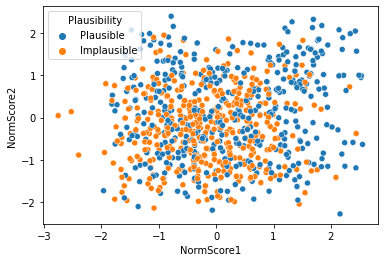

In [18]:
sns.scatterplot(data=plot_df, x="NormScore1", y="NormScore2", hue="Plausibility")
plt.show()

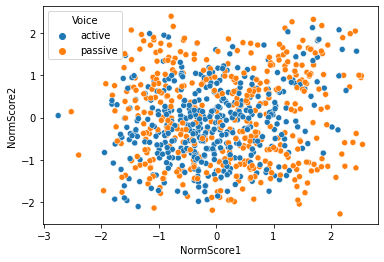

In [19]:
sns.scatterplot(data=plot_df, x="NormScore1", y="NormScore2", hue="Voice")
plt.show()

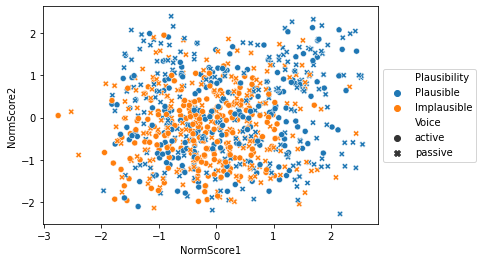

In [20]:
ax = sns.scatterplot(data=plot_df, x="NormScore1", y="NormScore2", hue="Plausibility", style="Voice")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
def correlation_scatterplot_main(ann_df,modelmetric_identifier):
    df = ann_df.loc[ann_df['Metric'] == modelmetric_identifier]
    
    #just as a sanity check
    outlier_sentence_nrs = find_outliers(df)
    
    df_synset1,df_synset2,plot_df = get_synonym_dfs(df)
    
    ax = sns.scatterplot(data=plot_df, x="NormScore1", y="NormScore2", hue="Plausibility", style="Voice")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f'{modelmetric_identifier}')
    plt.xlabel('normed score for synonym 1')
    plt.ylabel('normed score for synonym 2')
    plt.show()

In [22]:
modelmetrics = list(np.unique(ann_df['Metric']))
modelmetrics

['new-EventsAdapt.bert-large-cased.last-word-prob',
 'new-EventsAdapt.bert-large-cased.sentence-probs-pseudolog',
 'new-EventsAdapt.bert-large-cased.verb-prob',
 'new-EventsAdapt.roberta-large.last-word-prob',
 'new-EventsAdapt.roberta-large.sentence-probs-pseudolog',
 'new-EventsAdapt.roberta-large.verb-prob',
 'new-EventsAdapt.xlnet-large-cased.last-word-prob',
 'new-EventsAdapt.xlnet-large-cased.sentence-probs-pseudolog',
 'new-EventsAdapt.xlnet-large-cased.verb-prob',
 'new-EventsAdapt_fast_vector_sum',
 'new-EventsAdapt_v2_sdm',
 'new-eventsAdapt_gpt2-xl_full',
 'new-eventsAdapt_gpt2_full',
 'newsentences-EventsAdapt.scores_baseline2_ppmi',
 'newsentences-EventsAdapt.update-model.TF-add',
 'newsentences-EventsAdapt.update-model.TF-prod',
 'newsentences_EventsAdapt.scores_baseline1_ppmi']

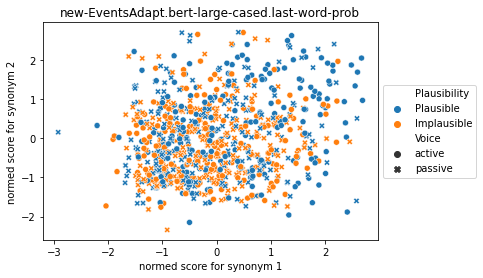

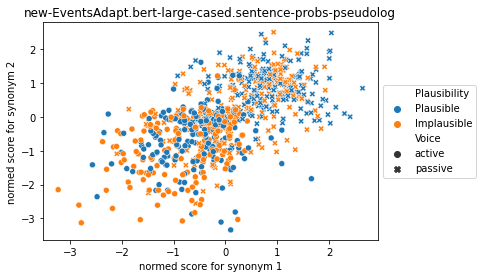

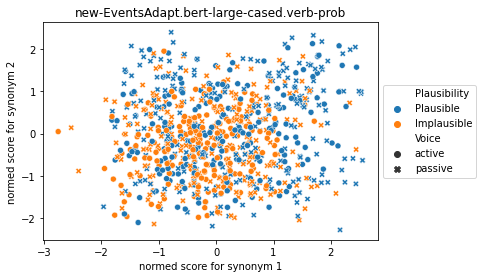

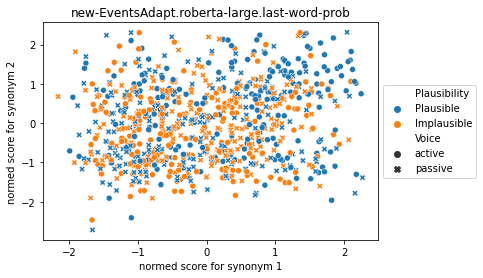

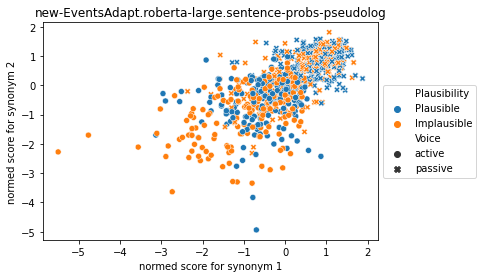

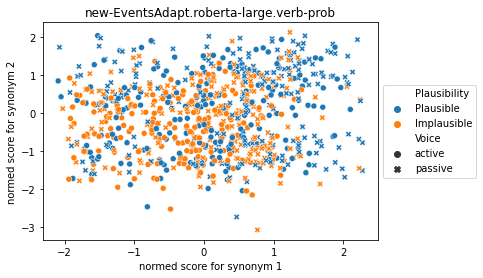

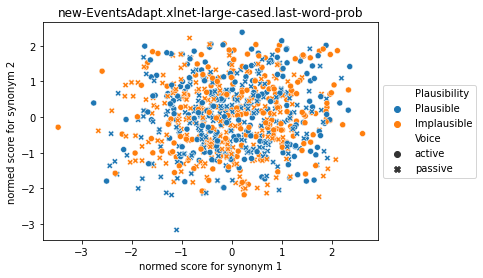

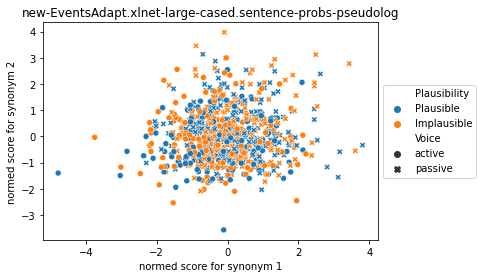

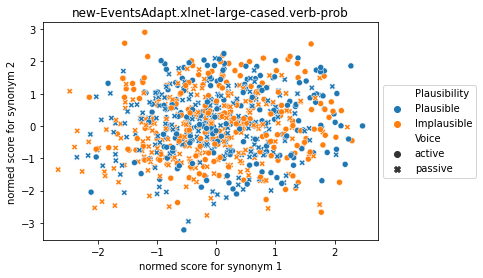

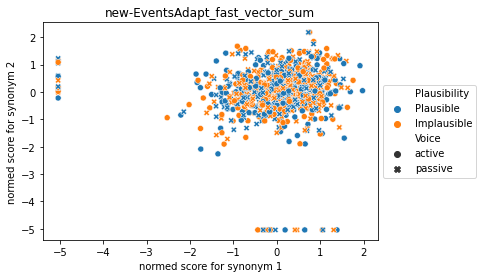

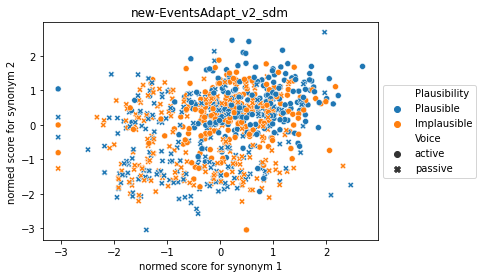

124 The author finished the novel. 14.178987150252366
1120 The attendant pressed the button. 6.624418559349059
1192 The poker player won the game. 36.85959503696578


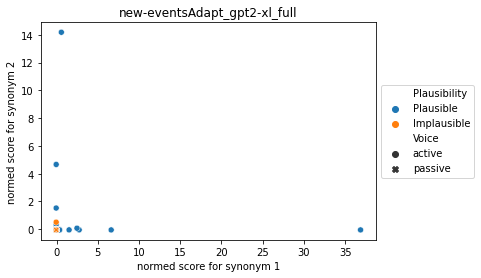

1192 The poker player won the game. 40.58242366305091


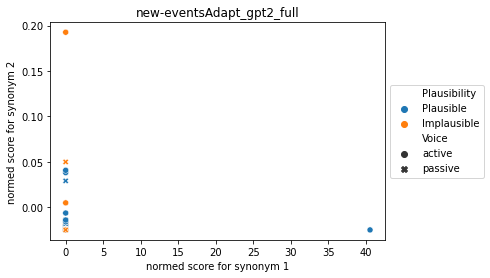

1580 The ex-wife punched the girlfriend. 10.66340260568358


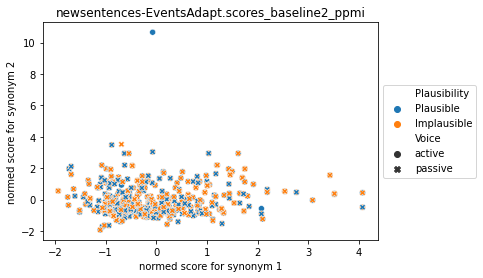

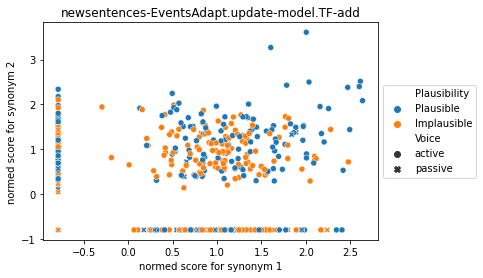

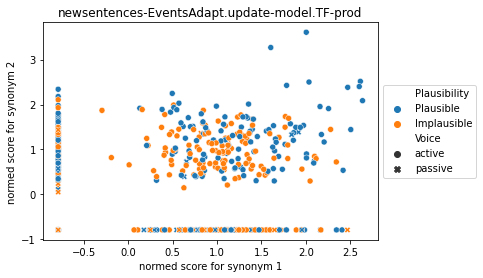

1580 The ex-wife punched the girlfriend. 8.148443201935438


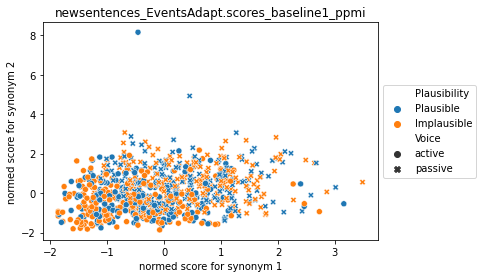

In [23]:
for metric in modelmetrics:
    correlation_scatterplot_main(ann_df,metric)